In [1]:
import torch
import sys
import numpy as np
import pandas as pd
import scanpy.api as sc
from anndata import AnnData
#import h5py
#import anndata as ad

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

sys.path.append("../")
from args_parser import get_parser
from model.mars import MARS
from model.experiment_dataset import ExperimentDataset
from data.benchmarks import BenchmarkData
import warnings
warnings.filterwarnings('ignore')

/pollard/home/zhhu/miniconda3/envs/mars2/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


# Setting parameters

Loading default parameters

In [2]:
params, unknown = get_parser().parse_known_args()

In [3]:
params

Namespace(cuda=False, epochs=30, epochs_pretrain=25, learning_rate=0.001, lr_scheduler_gamma=0.5, lr_scheduler_step=20, manual_seed=3, model_file='trained_models/source.pt', pretrain=True, pretrain_batch=None)

Checking if CUDA device is available

In [4]:
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'
params.device = device

In [5]:
def init_seed(opt):
    torch.cuda.cudnn_enabled = False
    np.random.seed(opt.manual_seed)
    torch.manual_seed(opt.manual_seed)
    torch.cuda.manual_seed(opt.manual_seed)
init_seed(params)

# Prepare integrated and scaled data (only highly variable genes)

In [8]:
workdir = '/pollard/data/projects/zhhu/cellwalk/blood_cellTyist'
import os

In [9]:
dat = pd.read_csv(os.path.join(workdir, "blood_integrated_scaled.csv"), index_col = 0) #3000 × 42484

In [10]:
meta = pd.read_csv(os.path.join(workdir, 'merge_Ren_Yoshida_meta.csv'), index_col=0)

In [18]:
meta = meta.loc[dat.columns,]

In [21]:
all(meta.index == dat.columns)

True

In [22]:
adata = AnnData(dat.values.transpose())
adata

adata.obs_names = dat.columns
adata.var_names = dat.index
print(adata.obs_names[:10])

Index(['TAAGCGTGTAAGCACG-53', 'CGCGTTTCACAAGCCC-32', 'CAACCTCGTACGACCC-61',
       'TGCACCTCATCCGTGG-53', 'AACTGGTGTGTGAATA-132', 'AGAGTGGAGGGCTTCC-52',
       'GAGGTGACAACTGCGC-117', 'CTAGCCTTCTTGTTTG-117', 'GAATAAGCACTGCCAG-34',
       'CGGACACAGCCTTGAT-253'],
      dtype='object')


In [23]:
adata.obs['study'] =  meta.Dataset
adata.obs['ground_truth'] = meta.Original_annotation
adata

AnnData object with n_obs × n_vars = 42484 × 3000 
    obs: 'study', 'ground_truth'

In [25]:
adata.write(os.path.join(workdir,'blood_integrated_scaled.h5ad'))

... storing 'study' as categorical
... storing 'ground_truth' as categorical


# Loading dataset

In [26]:
adata = sc.read_h5ad(os.path.join(workdir,'blood_integrated_scaled.h5ad'))
adata

AnnData object with n_obs × n_vars = 42484 × 3000 
    obs: 'study', 'ground_truth'

In [ ]:
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#sc.pp.scale(adata, max_value=10, zero_center=True)

In [27]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')
sc.pp.pca(adata, n_comps=50)
sc.tl.tsne(adata, n_jobs = 5 )


IndexError: Key "experiment" is not valid observation/variable name/index.

<Figure size 989.28x288 with 0 Axes>

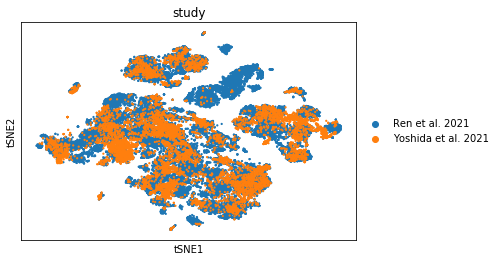

In [30]:
sc.pl.tsne(adata, color=['study'],size=20)

In [31]:
adata.obs['ct_low'] = adata.obs.ground_truth.astype('str').copy()

In [32]:
idx = adata.obs.ground_truth.str.contains('NK').values
adata.obs['ct_low'][idx] = 'Nature killer'

idx = adata.obs.ground_truth.str.contains('^T|MAIT|NKT').values
adata.obs['ct_low'][idx] = 'T cells'

idx = adata.obs.ground_truth.str.contains('^B|Plasma').values
adata.obs['ct_low'][idx] = 'B cells'

idx = adata.obs.ground_truth.str.contains('^Mono|Macro').values
adata.obs['ct_low'][idx] = 'Monocytes'

idx = ((adata.obs.ground_truth == 'Mega') | 
       (adata.obs.ground_truth == 'Platelets'))
adata.obs['ct_low'][idx] = 'Megakaryocyte'

idx = adata.obs.ground_truth.str.contains('DC').values
adata.obs['ct_low'][idx] = 'Dendritic cells'

In [33]:
adata.obs['ct_low'].value_counts()

T cells            27225
Monocytes           6650
B cells             4688
Nature killer       3118
Dendritic cells      496
Megakaryocyte        247
Cycling               32
HPC                   11
ILC                   10
Neu_c3-CST7            7
Name: ct_low, dtype: int64

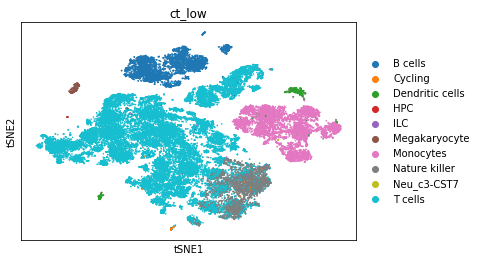

In [38]:
sc.pl.tsne(adata, color=['ct_low'],size=10)

In [39]:
datasets = list(set(adata.obs['study']))
datasets

['Yoshida et al. 2021', 'Ren et al. 2021']

# Train and evaluate MARS

### Use science dataset as annotated, and geschwind as unannotated 

Prepare annotated, unannotated and pretrain datasets

In [40]:
science = adata[adata.obs['study'] == 'Ren et al. 2021',:]
geschwind = adata[adata.obs['study'] == 'Yoshida et al. 2021',:]

In [41]:
 def celltype_to_numeric(adata, annotation_type):
        """Adds ground truth clusters data."""
        annotations = list(adata.obs[annotation_type])
        annotations_set = sorted(set(annotations))
        
        mapping = {a:idx for idx,a in enumerate(annotations_set)}
        
        truth_labels = [mapping[a] for a in annotations]
        adata.obs['truth_labels'] = pd.Categorical(values=truth_labels)
         
        return mapping

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# label = le.fit_transform(kolod.obs['ground_truth'])
# label2 = le.fit_transform(pollen.obs['ground_truth'])
# 

In [42]:
celltype_id_map_science = celltype_to_numeric(science, 'ground_truth')
IDs_to_celltypes_science = {v:k for k,v in celltype_id_map_science.items()}
celltype_id_map_geschwind = celltype_to_numeric(geschwind, 'ground_truth')
IDs_to_celltypes_geschwind = {v:k for k,v in celltype_id_map_geschwind.items()}

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [43]:
y_science = np.array(science.obs['truth_labels'], dtype=np.int64)
annotated = ExperimentDataset(science.X, science.obs_names, science.var_names, 'science', y_science)

== Dataset: Found 33123 items 
== Dataset: Found 46 classes


In [44]:
y_geschwind = np.array(geschwind.obs['truth_labels'], dtype=np.int64) # ground truth annotations will be only used for evaluation
unannnotated = ExperimentDataset(geschwind.X, geschwind.obs_names, geschwind.var_names, 'geschwind', y_geschwind)

== Dataset: Found 9361 items 
== Dataset: Found 34 classes


In [45]:
pretrain_data = ExperimentDataset(geschwind.X, geschwind.obs_names, geschwind.var_names, 'geschwind')

In [46]:
n_clusters = len(np.unique(unannnotated.y))

In [48]:
params.epochs = 100

Initialize MARS

In [49]:
mars = MARS(n_clusters, params, [annotated], unannnotated, pretrain_data, hid_dim_1=1000, hid_dim_2=100)
#mars = MARS(n_clusters, params, [annotated], unannnotated, pretrain_data, hid_dim_1=1000, hid_dim_2=200)

Run MARS in evaluation mode. Ground truth annotations will be used to evaluate MARS performance and scores will be returned

In [50]:
# return both annotated and unannotated datasets with save_all_embeddings
adata, landmarks, scores = mars.train(evaluation_mode=True, save_all_embeddings=True) # evaluation mode

Pretraining..

=== Epoch: 100 ===
Train acc: 0.5026114583015442


In [52]:
scores


{'precision': 0.41197824947999384,
 'accuracy': 0.5088131609870741,
 'adj_rand': 0.431367532276024,
 'nmi': 0.6649311009957609,
 'adj_mi': 0.6212978681525614,
 'recall': 0.37862534010483057,
 'f1_score': 0.348573873570567}

Check MARS performance

In [53]:
def hungarian_match(y_true, y_pred):
    """Matches predicted labels to original using hungarian algorithm."""
    
    #y_true = adjust_range(y_true)
    #y_pred = adjust_range(y_pred)
    
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    # Confusion matrix.
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(-w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    d = {i:j for i, j in ind}
    y_pred = np.array([d[v] for v in y_pred])
    
    return y_true, y_pred, d

In [54]:
from scipy.optimize import linear_sum_assignment 

In [61]:
geschwind = adata[adata.obs['experiment'] == 'geschwind',:]
y_true, y_pred, d = hungarian_match(geschwind.obs['truth_labels'], geschwind.obs['MARS_labels'])

In [62]:
geschwind

View of AnnData object with n_obs × n_vars = 9361 × 3000 
    obs: 'MARS_labels', 'experiment', 'truth_labels'
    obsm: 'MARS_embedding'

In [63]:
d

{0: 12,
 1: 30,
 2: 3,
 3: 22,
 4: 7,
 5: 19,
 6: 29,
 7: 28,
 8: 20,
 9: 14,
 10: 24,
 11: 21,
 12: 13,
 13: 25,
 14: 1,
 15: 15,
 16: 33,
 17: 2,
 18: 17,
 19: 32,
 20: 18,
 21: 11,
 22: 23,
 23: 16,
 24: 0,
 25: 9,
 26: 8,
 27: 31,
 28: 10,
 29: 27,
 30: 26,
 31: 6,
 32: 5,
 33: 4}

In [64]:
name_maps = mars.name_cell_types(adata, landmarks, IDs_to_celltypes_science)


Cluster label: 0
Mono_c1-CD14-CCL3: 4.694140628284294e-18
Mono_c2-CD14-HLA-DPB1: 1.1697971487099203e-17
Mono_c3-CD14-VCAN: 3.95438892909274e-17
Mono_c4-CD14-CD16: 5.955532018051235e-16
Mono_c5-CD16: 0.9999999999999994

Cluster label: 1
Unassigned

Cluster label: 2
T_CD4_c09-GZMK-FOS_l: 1.8347327656533775e-29
B_c04-SOX5-TNFRSF1B: 1.1261039828568913e-26
B_c03-CD27-AIM2: 1.9365445337820707e-18
B_c02-MS4A1-CD27: 3.3665295033385385e-17
B_c01-TCL1A: 1.0

Cluster label: 3
T_CD4_c07-AHNAK: 0.006728794664878713
T_CD4_c09-GZMK-FOS_l: 0.027184145061595458
T_CD8_c02-GPR183: 0.2829797701873785
T_CD4_c08-GZMK-FOS_h: 0.3238770059740689
T_CD8_c01-LEF1: 0.32778543555615053

Cluster label: 4
T_CD8_c07-TYROBP: 1.6441751044546973e-149
NK_c01-FCGR3A: 2.697950068147596e-81
T_CD4_c10-IFNG: 6.022204321823427e-81
T_CD8_c08-IL2RB: 4.2090788851159263e-79
NK_c02-NCAM1: 1.0

Cluster label: 5
Unassigned

Cluster label: 6
T_CD4_c01-LEF1: 1.6268562325346005e-18
T_CD4_c08-GZMK-FOS_h: 1.3922134464400638e-16
T_CD4_c09-

In [72]:
confusion = pd.DataFrame(data=np.zeros((34, 46)), columns = celltype_id_map_science.keys())
for idx in name_maps:
    for x in name_maps[idx]:
        confusion.loc[idx,x[0]] = x[1]

confusion.index = [IDs_to_celltypes_geschwind[d[v]] for v in d.keys()]

In [76]:
confusion.to_csv(os.path.join(workdir, 'blood_mars_confusion.csv'))

In [88]:
confusion.loc['Platelets',]

B_c01-TCL1A               0
B_c02-MS4A1-CD27          0
B_c03-CD27-AIM2           0
B_c04-SOX5-TNFRSF1B       0
B_c05-MZB1-XBP1           0
B_c06-MKI67               0
DC_c1-CLEC9A              0
DC_c2-CD1C                0
DC_c4-LILRA4              0
Macro_c2-CCL3L1           0
Mega                      0
Mono_c1-CD14-CCL3         0
Mono_c2-CD14-HLA-DPB1     0
Mono_c3-CD14-VCAN         0
Mono_c4-CD14-CD16         0
Mono_c5-CD16              0
NK_c01-FCGR3A             0
NK_c02-NCAM1              0
NK_c03-MKI67              0
Neu_c3-CST7               0
T_CD4_c01-LEF1            0
T_CD4_c02-AQP3            0
T_CD4_c03-ITGA4           0
T_CD4_c04-ANXA2           0
T_CD4_c05-FOS             0
T_CD4_c06-NR4A2           0
T_CD4_c07-AHNAK           0
T_CD4_c08-GZMK-FOS_h      0
T_CD4_c09-GZMK-FOS_l      0
T_CD4_c10-IFNG            0
T_CD4_c11-GNLY            0
T_CD4_c12-FOXP3           0
T_CD4_c13-MKI67-CCL5_l    0
T_CD8_c01-LEF1            0
T_CD8_c02-GPR183          0
T_CD8_c03-GZMK      